# 1. Churn Analysis

In [10]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
pd.set_option('display.max_columns', None)
import datetime
from dateutil.relativedelta import relativedelta

## Cohort 2023-07-01

In [11]:
# Define the date and format it as a string in the required format
start_date = datetime.date(2023, 7, 1)
date_str = start_date.strftime('%Y-%m-%d')

## Total Registered Customers before 2023-07-01

In [12]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
)
select * from all_cust ;"""
df = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
print(f"The total registered customers as of {date_str} are:\t{df['registered_users'].nunique()}")

Job ID 3fb20b2b-2f6a-4deb-a75b-d740f7603c90 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The total registered customers as of 2023-07-01 are:	1115462


## Open TSA Customers

In [13]:
# Define the date and format it as a string in the required format
start_date = datetime.date(2023, 7, 1)
date_str = start_date.strftime('%Y-%m-%d')

# Format the SQL string with the date variable
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) 
    select * from open_TSA_cust;
"""

# Execute the query and convert to a DataFrame
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Open TSA customers before the cutoff date of {date_str} out of the total registered customer are:\t {df['open_TSA_customers'].nunique()}")

df.head()


Job ID 5b9cde7b-1681-4e83-9904-20aca1678682 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Open TSA customers before the cutoff date of 2023-07-01 out of the total registered customer are:	 567222


,open_TSA_customers
0,1192689
1,1192893
2,1192647
3,1192847
4,1192862


In [14]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            ) 
    select customerwithactiveloan from loan_cust;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

print(f"The Customer with active loan on the cutoff date of {date_str} are: {df['customerwithactiveloan'].nunique()}")
df.head()

Job ID ddca1807-91d7-4634-949a-c284bedaab89 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Customer with active loan on the cutoff date of 2023-07-01 are: 29170


,customerwithactiveloan
0,1374388
1,1593085
2,1080331
3,1955739
4,1382697


## ACL Customers

In [15]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                )
    select * from ACL_Customer;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The count ACL customer before the cutoff date of {date_str} are:{df['customerId'].nunique()}")

df.head()

Job ID 11bcd85e-8e70-4f5a-8033-0cd1b17e5714 successfully executed: 100%|██████████|
Downloading: |          |
The count ACL customer before the cutoff date of 2023-07-01 are:0


,customerId


In [16]:
sq = f"""WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    )
    select * from non_ACL_cust;"""
    
df =client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Non ACL customer count is:{df['customerId'].nunique()}")

df.head()    

Job ID 45c3999b-a8fe-4a48-abbe-85127bad3a20 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Non ACL customer count is:1086292


,customerId
0,1071617
1,1269099
2,1268757
3,1269539
4,1269567


**Definition of MAU**<br>
<br>
1.  Customer who do not have have active loan as of the cutoff date<br>
2.  Customer who have done >= 100 peso Transaction before the cutoff date. <br>
3.  Customer who have >=100 peso balance in any of the TSA, Stash or Individual Stash accounts. <br>
4.  Customer who have >=100 peso balance in the TSA, Stash and Individual Stash accounts combined. <br>

## Create the table dap_ds_poweruser_playground.temp_customer_select to store all the customer id who were active at the cohort

In [17]:
sq = """drop table if exists dap_ds_poweruser_playground.temp_customer_select;"""

# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table dropped successfully.")

Table dropped successfully.


In [18]:
sq = f"""
    create table prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select as 
    WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    ),        
    MAU_with_trx --- Customers who at the cutoff date had a transaction of over 100 peso or more
    AS (
        SELECT DISTINCT customer_id 
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date <= date("{date_str}")                            --- Transaction date should be less than the cutoff date
        AND ABS(trx_amount) >= 100                                              --- transaction greater than 100
        AND account_type = "Tonik Account"                                      --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)   --- no active loan
        AND customer_id in (select open_TSA_customers from open_TSA_cust)       --- Active TSA Account
        )
        ,
    MAU_with_bal 
     AS (
        SELECT 
            DISTINCT client_id 
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance >= 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case when account_type like 'Individual Stash' then clearedbalance else 0 end)) >=100
            )                                                                       ---- Balance combined or individual should be more than 100 pseo
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")  ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf <= date("{date_str}") ---- before cutoff date       ---- Balance Date should be less than cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)     ---- Should not have any active loans
            AND client_id in (select open_TSA_customers from open_TSA_cust)         ---- Customer should have active open TSA account
        )         ,
    MAU --- 
        AS (
        SELECT distinct customer_id AS MAU 
        , case when customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction and balance more than 100 peso'
               when  customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id not in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso'
               when  customer_id not in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done no transaction more than 100 peso but have balance more than 100 peso'
               End Mau_condition
        FROM 
            (SELECT customer_id 
            FROM 
                MAU_with_trx
            UNION DISTINCT
            SELECT 
                client_id AS customer_id
            FROM 
                MAU_with_bal))
    select * from MAU;"""
    
# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table successfully Created")



Table successfully Created


In [19]:
df = client.query("""select * from dap_ds_poweruser_playground.temp_customer_select;""").to_dataframe(progress_bar_type='tqdm')

print(f"The count of customer Distribution in MAU before the cutoff date {date_str} is {df.groupby('Mau_condition')['MAU'].nunique()}")
print(f"The count of customer in MAU before the cutoff date {date_str} is {df['MAU'].nunique()}")

Job ID 2381d1b3-bd47-4694-95f4-7ad9c5f876af successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The count of customer Distribution in MAU before the cutoff date 2023-07-01 is Mau_condition
Customer done no transaction more than 100 peso but have balance more than 100 peso                      2959
Customer done transaction and balance more than 100 peso                                               125246
Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso     23149
Name: MAU, dtype: int64
The count of customer in MAU before the cutoff date 2023-07-01 is 151354


In [20]:
df.head()

,MAU,Mau_condition
0,1236317,Customer done transaction and balance more tha...
1,1301540,Customer done transaction and balance more tha...
2,1274304,Customer done transaction and balance more tha...
3,2093495,Customer done transaction and balance more tha...
4,2000459,Customer done transaction and balance more tha...


## Check whether we have active loan before the cutoff date

In [21]:
sq = """with loandf as 
(select lmt.customerId, lmt.loanAccountNumber, lmt.disbursementDateTime,lbfrc.bucketDate, lbfrc.loanStatus  
from `risk_credit_mis.loan_master_table` lmt 
inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
where lmt.flagDisbursement = 1)
select *,  
(select max(loanAccountNumber) from loandf where cast(customerId as string) = a.MAU and date_trunc(disbursementDateTime, day) <= '2023-07-01' 
and bucketDate = '2023-06-30' and loanStatus in ('Normal', 'In Arrears')
group by customerId) loanaccount
from prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select a
;
"""
dfd = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

print(dfd['loanaccount'].value_counts(dropna=False))

if dfd['loanaccount'].notna().any():
    print("There is a problem: We have loanAccountNumber active before cutoff date.")
else:
    print("Everything is all right: All loanaccount values are None.")

Job ID db00ac17-44ce-48dc-824c-1bb7c86b827d successfully executed: 100%|██████████|
Downloading: 100%|██████████|
loanaccount
None    151354
Name: count, dtype: int64
Everything is all right: All loanaccount values are None.


I now have a dataframe df with Monthly active customer MAU as of cutoff date 2023-07-01 <br>

I need to check now for each subsequent month out of these customers who have never have any:<br> 
1.  active loan, 
2.  Never transacted more than 100 peso
3.  Never have combined balance more than 100 peso
4.  Do not have any active TD account within the date range
5.  TSA is closed after cutoff date after 60 days
6.  TSA is closed after 180 days from the cutoff date


Cohort of 1st of February


In [22]:
import pandas as pd
from datetime import datetime, timedelta

# Start date as the month after 2023-07-01
start_date = pd.to_datetime("2023-07-01") 
# + pd.DateOffset(months=1)
# Today's date
end_date = datetime.today()
# end_date = pd.to_datetime("2023-12-01") 

# Generate month start and month end dates
month_dates = []
current_date = start_date

while current_date <= end_date:
    month_start = current_date.replace(day=1)
    next_month = month_start + pd.DateOffset(months=1)
    month_end = (next_month - timedelta(days=1)) if next_month <= end_date else end_date
    
    month_dates.append((month_start, month_end))
    current_date = next_month

# Display the result
res =  pd.DataFrame()
for start, end in month_dates:
    print(f"Month Start: {start.strftime('%Y-%m-%d')}, Month End: {end.strftime('%Y-%m-%d')}")
    date_str = start.strftime('%Y-%m-%d')
    sq = f"""with 
        loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
        AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)                                   --- bucketDate should be equal to d-1 of cutoff date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')                                                        --- loan paid status should be Normal or In Arears indicating active loans
        and CAST(lmt.customerId AS STRING) in (select MAU from dap_ds_poweruser_playground.temp_customer_select)--- customer from the MAU list before cutoff date
                  ),
        TD_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE not in ('POC20000', 'POC20600', 'POC20400', 'POC20200', 'NULL')   
                            AND
                            (OFDATECLOSED = '1970-01-01' or OFDATECLOSED >= '{date_str}')
                            AND OFDATEOPENED <='{date_str}'
        ),
        TSAClosed60_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND (OFDATECLOSED >= '{date_str}' and OFDATECLOSED <= date_add('{date_str}', interval 60 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        TSAClosed180_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND  OFDATECLOSED > '{date_str}' 
                            AND (OFDATECLOSED > date_add('{date_str}', interval 60 day) AND OFDATECLOSED <= date_add('{date_str}', interval 180 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        MAU_with_trx 
        AS (
        SELECT customer_id , max(trx_amount) condition
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date >= date("{date_str}")                                --- transaction date greater or equal to cutoff dates
        AND ABS(trx_amount) < 100                                                   --- transaction greater than 100
        AND account_type = "Tonik Account"                                          --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)       --- no active loan
        AND customer_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                   --- NO ACTIVE TD ACCOUNT
        group by 1
        )
        ,
        MAU_with_bal 
        AS (
        SELECT 
            client_id, max(clearedbalance) condition
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance < 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case     when account_type like 'Individual Stash' then clearedbalance else 0 end)) < 100
            )
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")      ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf > date("{date_str}")                                    ---- before cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)         ---- no active loans 
            AND client_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                     ---- no active TD account   
            group by 1
        ),
        MAUunion as 
        (
        select *, 'trx' tab from MAU_with_trx
        union distinct
        select *, 'bal' tab from MAU_with_bal
        ), 
        MAUfinal as 
        (select customer_id, max(condition) val, count(distinct tab) cnt_condition
        , max(case when tab = 'trx' then condition else 0 end) trx_amount
        , max(case when tab = 'bal' then condition else 0 end) balanceamt
        , (select max(loanAccountNumber) from `risk_credit_mis.loan_master_table` 
                                        where cast(customerId as string) = customer_id 
                                        and date_trunc(disbursementDateTime, day) >= '{date_str}') loancount
        from MAUunion
        group by 1
        ),
        TSAClosed as 
        (select OFCUSTOMERID, OFDATECLOSED from `core_raw.customer_accounts` 
        where OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select) and CRINTERCODE = 'POC20000' and OFDATECLOSED is not null)
    select 
    (select count(distinct MAU) from dap_ds_poweruser_playground.temp_customer_select) MAUcustomerbeforecutoff,
    count(distinct customer_id) cntcustomer, 
    (select count(distinct OFCUSTOMERID) from TSAClosed where OFDATECLOSED >= '{date_str}') TSAclosed_count,
    (select count(distinct OFCUSTOMERID) from TSAClosed60_cust) TSAClosedAfter60daysofinactivity,
    (select count(distinct OFCUSTOMERID) from TSAClosed180_cust)TSAClosedAfter180daysofinactivity,
    count(distinct case when val > 1 and val < 100 then customer_id end) greaterthan1lessthan100peso,
    count(distinct case when val < 1 then customer_id end) lessthan1peso,
    count(distinct case when cnt_condition > 1 then customer_id end) twoconditionmet,
    count(distinct case when cnt_condition <= 1 then customer_id end) onlyoneconditionmet,
    count(distinct case when trx_amount > 100 then customer_id end) trx_amt_morethan_100,
    count(distinct case when trx_amount between 1 and 100 then customer_id end) trx_amt_oneto100,
    count(distinct case when trx_amount < 1 then customer_id end) trx_amt_less_one,
    count(distinct case when balanceamt > 100 then customer_id end) balance_amt_morethan100,
    count(distinct case when balanceamt between 1 and 100 then customer_id end) balance_amt_oneto100,
    count(distinct case when balanceamt < 1 then customer_id end) balance_amt_less_one,
    count(distinct case when loancount is not null then customer_id end) loansapplied
    from MAUfinal
    where customer_id in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
    order by 1 desc        
    """
    df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
    df['StartDate'] = date_str
    df['StillChurn'] = round(df['cntcustomer']/df['MAUcustomerbeforecutoff']*100, 4)
    res = pd.concat([res,df])
    
res = res[['StartDate', 'MAUcustomerbeforecutoff', 'cntcustomer', 'StillChurn', 'TSAclosed_count',
        'TSAClosedAfter60daysofinactivity', 'TSAClosedAfter180daysofinactivity',
        'greaterthan1lessthan100peso',
       'lessthan1peso', 'twoconditionmet', 'onlyoneconditionmet',
       'trx_amt_morethan_100', 'trx_amt_oneto100', 'trx_amt_less_one',
       'balance_amt_morethan100', 'balance_amt_oneto100',
       'balance_amt_less_one', 'loansapplied']].copy()
res

Month Start: 2023-07-01, Month End: 2023-07-31
Job ID c0717513-1bab-4ac5-a208-6984108b8b1d successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-08-01, Month End: 2023-08-31
Job ID 75ce588a-095e-4140-b8d4-34ca74c2a9fe successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-09-01, Month End: 2023-09-30
Job ID 9fcad2e2-c654-4f62-9c82-424286a6b681 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-10-01, Month End: 2023-10-31
Job ID f4046fe4-99fc-464d-a417-39b0eb73ceab successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-11-01, Month End: 2023-11-30
Job ID 5b0b1262-e3e1-41c9-b9c9-9cd2692777a7 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-12-01, Month End: 2023-12-31
Job ID b092539e-9e52-4351-9e39-c6cef9378f05 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-01-01, Month End: 2024-01-31
Job ID d9ce

,StartDate,MAUcustomerbeforecutoff,cntcustomer,StillChurn,TSAclosed_count,TSAClosedAfter60daysofinactivity,TSAClosedAfter180daysofinactivity,greaterthan1lessthan100peso,lessthan1peso,twoconditionmet,onlyoneconditionmet,trx_amt_morethan_100,trx_amt_oneto100,trx_amt_less_one,balance_amt_morethan100,balance_amt_oneto100,balance_amt_less_one,loansapplied
0,2023-07-01,151354,90733,59.9475,30688,4676,9362,53291,37263,15476,75257,0,10991,79742,0,52571,38162,2130
0,2023-08-01,151354,87568,57.8564,28052,2476,10765,51673,35717,13975,73593,0,9922,77646,0,51137,36431,1630
0,2023-09-01,151354,85240,56.3183,26003,5330,6678,50510,34564,12759,72481,0,9070,76170,0,50045,35195,1283
0,2023-10-01,151354,84353,55.7323,25576,7380,6535,49649,34540,11876,72477,0,8400,75953,0,49224,35129,1029
0,2023-11-01,151354,79573,52.5741,20673,4078,8508,48638,30767,11090,68483,0,7812,71761,0,48250,31323,901
0,2023-12-01,151354,77148,50.9719,18196,3405,7749,48040,28942,10453,66695,0,7307,69841,0,47685,29463,853
0,2024-01-01,151354,75582,49.9372,16595,2626,8202,47488,27933,9839,65743,0,6829,68753,0,47140,28442,808
0,2024-02-01,151354,73744,48.7229,14777,3201,5929,46835,26751,9153,64591,0,6300,67444,0,46500,27244,773
0,2024-03-01,151354,72804,48.1018,13970,5900,3084,46284,26366,8424,64380,0,5775,67029,0,45986,26818,737
0,2024-04-01,151354,70650,46.6786,11606,4618,6564,45810,24687,7826,62824,0,5334,65316,0,45530,25120,717


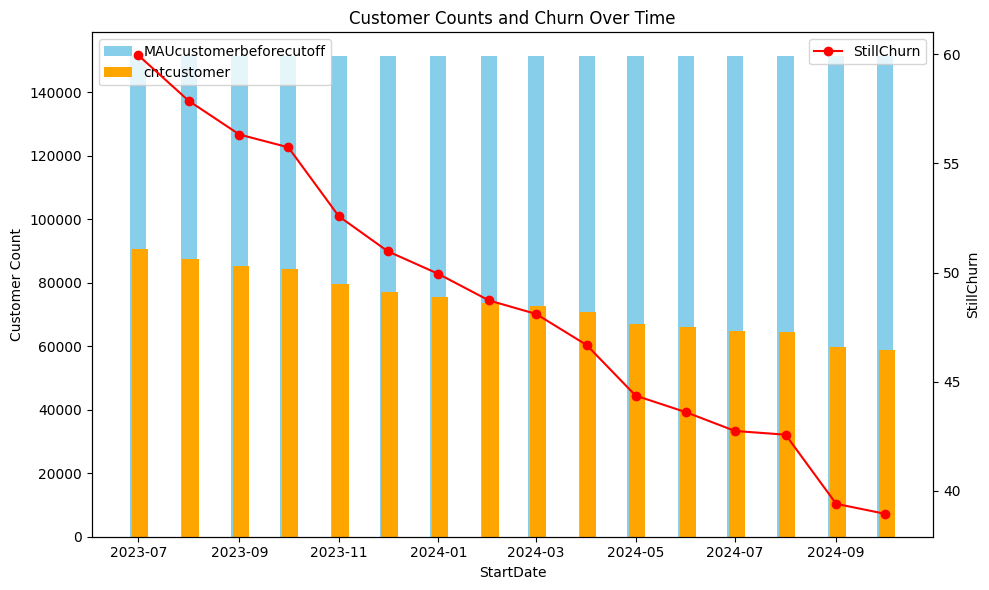

In [23]:
# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Increase the width of the bars
bar_width = 10  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')
ax2.legend(loc='upper right')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

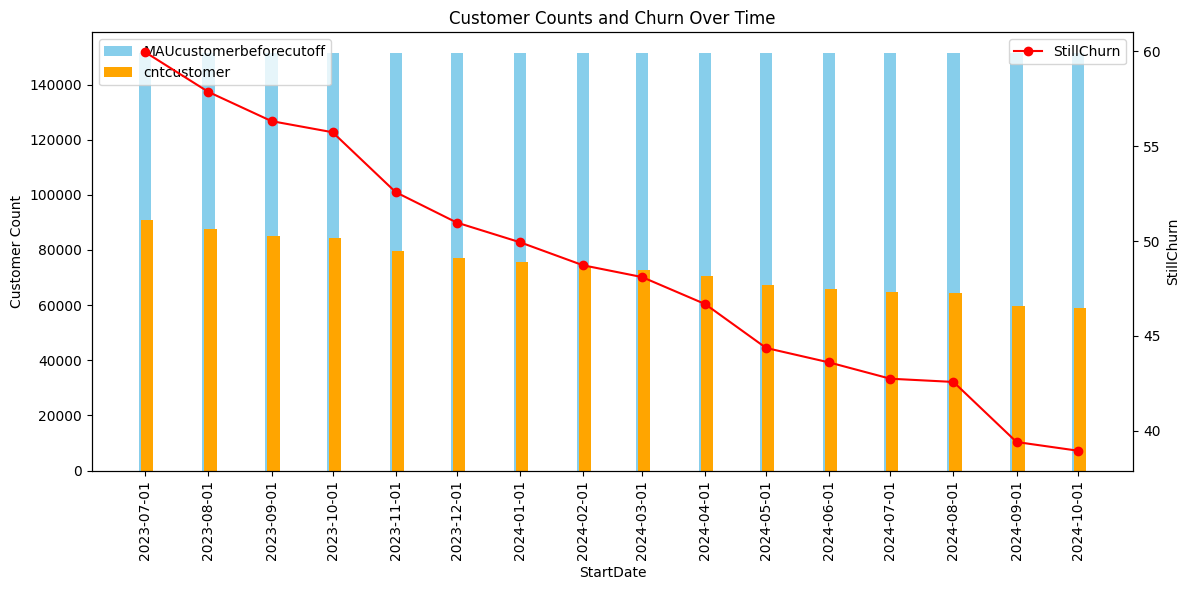

In [24]:
# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Increase the width of the bars
bar_width = 6  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')
ax2.legend(loc='upper right')

# Rotate X-axis labels to be vertical
ax1.set_xticks(res['StartDate'])  # Ensures all x-axis labels are shown
ax1.set_xticklabels(res['StartDate'].dt.strftime('%Y-%m-%d'), rotation=90, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
res.to_excel(r"Churn_analysis_cohort20230701.xlsx")

## Cohort 2024-02-01

In [26]:
import datetime

start_date = datetime.date(2024, 2, 1)
date_str = start_date.strftime('%Y-%m-%d')

## Total Registered Customers before 2024-02-01

In [27]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
)
select * from all_cust ;"""
df = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
print(f"The total registered customers are:{df['registered_users'].nunique()}")

Job ID c61f7a7a-43b0-4422-96fa-55e71cf7147f successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The total registered customers are:1386769


## Open TSA Customers

In [28]:
# Define the date and format it as a string in the required format
start_date = datetime.date(2024, 2, 1)
date_str = start_date.strftime('%Y-%m-%d')

# Format the SQL string with the date variable
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) 
    select * from open_TSA_cust;
"""

# Execute the query and convert to a DataFrame
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Open TSA customers before the cutoff date out of the total registered customer are:\t {df['open_TSA_customers'].nunique()}")

df.head()


Job ID 7363c8d8-ef61-4538-a3bf-14ea56b8ae6b successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Open TSA customers before the cutoff date out of the total registered customer are:	 521008


,open_TSA_customers
0,1000460
1,1696302
2,1693862
3,1696534
4,1695487


In [29]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            ) 
    select customerwithactiveloan from loan_cust;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

print(f"The Customer with active loan on the cutoff date are: {df['customerwithactiveloan'].nunique()}")
df.head()

Job ID 21fa858f-f537-4bdd-8014-c843cf61c621 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Customer with active loan on the cutoff date are: 53314


,customerwithactiveloan
0,2268401
1,1118783
2,1961153
3,2198834
4,2322430


## ACL Customers

In [30]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                )
    select * from ACL_Customer;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The count ACL customer before the cutoff date are:{df['customerId'].nunique()}")

df.head()

Job ID f192a767-5e08-4b8e-aa78-0dbb60cef65e successfully executed: 100%|██████████|
Downloading: |          |
The count ACL customer before the cutoff date are:0


,customerId


In [31]:
sq = f"""WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    )
    select * from non_ACL_cust;"""
    
df =client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Non ACL customer count is:{df['customerId'].nunique()}")

df.head()    

Job ID a6f1b82e-d675-45c7-8374-b0f05e516c79 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Non ACL customer count is:1333455


,customerId
0,1869994
1,1870307
2,1870458
3,1870735
4,1870733


## Create the table dap_ds_poweruser_playground.temp_customer_select to store all the customer id who were active at the cohort

In [32]:
sq = """drop table if exists dap_ds_poweruser_playground.temp_customer_select;"""

# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table dropped successfully.")

Table dropped successfully.


In [33]:
sq = f"""
    create table prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select as 
    WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    ),        
    MAU_with_trx --- Customers who at the cutoff date had a transaction of over 100 peso or more
    AS (
        SELECT DISTINCT customer_id 
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date <= date("{date_str}")                            --- Transaction date should be less than the cutoff date
        AND ABS(trx_amount) >= 100                                              --- transaction greater than 100
        AND account_type = "Tonik Account"                                      --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)   --- no active loan
        AND customer_id in (select open_TSA_customers from open_TSA_cust)       --- Active TSA Account
        )
        ,
    MAU_with_bal 
     AS (
        SELECT 
            DISTINCT client_id 
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance >= 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case when account_type like 'Individual Stash' then clearedbalance else 0 end)) >=100
            )                                                                       ---- Balance combined or individual should be more than 100 pseo
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")  ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf <= date("{date_str}") ---- before cutoff date       ---- Balance Date should be less than cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)     ---- Should not have any active loans
            AND client_id in (select open_TSA_customers from open_TSA_cust)         ---- Customer should have active open TSA account
        )         ,
    MAU --- 
        AS (
        SELECT distinct customer_id AS MAU 
        , case when customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction and balance more than 100 peso'
               when  customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id not in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso'
               when  customer_id not in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done no transaction more than 100 peso but have balance more than 100 peso'
               End Mau_condition
        FROM 
            (SELECT customer_id 
            FROM 
                MAU_with_trx
            UNION DISTINCT
            SELECT 
                client_id AS customer_id
            FROM 
                MAU_with_bal))
    select * from MAU;"""
    
# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table successfully Created")



Table successfully Created


In [34]:
df = client.query("""select * from dap_ds_poweruser_playground.temp_customer_select;""").to_dataframe(progress_bar_type='tqdm')

print(f"The count of customer Distribution in MAU before the cutoff date {date_str} is {df.groupby('Mau_condition')['MAU'].nunique()}")
print(f"The count of customer in MAU before the cutoff date {date_str} is {df['MAU'].nunique()}")

Job ID a13685a8-0d17-4701-83b6-890629141c52 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The count of customer Distribution in MAU before the cutoff date 2024-02-01 is Mau_condition
Customer done no transaction more than 100 peso but have balance more than 100 peso                      2499
Customer done transaction and balance more than 100 peso                                               137215
Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso     24366
Name: MAU, dtype: int64
The count of customer in MAU before the cutoff date 2024-02-01 is 164080


In [35]:
df.head()

,MAU,Mau_condition
0,1070268,Customer done transaction and balance more tha...
1,1398247,Customer done transaction and balance more tha...
2,1150113,Customer done transaction and balance more tha...
3,1767691,Customer done transaction and balance more tha...
4,1224577,Customer done transaction and balance more tha...


## Check whether we have active loan before the cutoff date

In [36]:
sq = """with loandf as 
(select lmt.customerId, lmt.loanAccountNumber, lmt.disbursementDateTime,lbfrc.bucketDate, lbfrc.loanStatus  
from `risk_credit_mis.loan_master_table` lmt 
inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
where lmt.flagDisbursement = 1)
select *,  
(select max(loanAccountNumber) from loandf where cast(customerId as string) = a.MAU and date_trunc(disbursementDateTime, day) <= '2024-02-01' 
and bucketDate = '2024-01-31' and loanStatus in ('Normal', 'In Arrears')
group by customerId) loanaccount
from prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select a
;
"""
dfd = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

print(dfd['loanaccount'].value_counts(dropna=False))

if dfd['loanaccount'].notna().any():
    print("There is a problem: We have loanAccountNumber active before cutoff date.")
else:
    print("Everything is all right: All loanaccount values are None.")

Job ID 336f16dd-3494-465c-8db9-f8ad4e762a54 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
loanaccount
None    164080
Name: count, dtype: int64
Everything is all right: All loanaccount values are None.


I now have a dataframe df with Monthly active customer MAU as of cutoff date 2023-07-01 <br>

I need to check now for each subsequent month out of these customers who have never have any:<br> 
1.  active loan, 
2.  Never transacted more than 100 peso
3.  Never have combined balance more than 100 peso
4.  Do not have any active TD account within the date range
5.  TSA is closed after cutoff date after 60 days
6.  TSA is closed after 180 days from the cutoff date


Cohort of 1st of February


In [37]:
import pandas as pd
from datetime import datetime, timedelta

# Start date as the month after 2023-07-01
start_date = pd.to_datetime("2024-02-01") 
# + pd.DateOffset(months=1)
# Today's date
end_date = datetime.today()
# end_date = pd.to_datetime("2023-12-01") 

# Generate month start and month end dates
month_dates = []
current_date = start_date

while current_date <= end_date:
    month_start = current_date.replace(day=1)
    next_month = month_start + pd.DateOffset(months=1)
    month_end = (next_month - timedelta(days=1)) if next_month <= end_date else end_date
    
    month_dates.append((month_start, month_end))
    current_date = next_month

# Display the result
res =  pd.DataFrame()
for start, end in month_dates:
    print(f"Month Start: {start.strftime('%Y-%m-%d')}, Month End: {end.strftime('%Y-%m-%d')}")
    date_str = start.strftime('%Y-%m-%d')
    sq = f"""with 
        loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
        AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)                                   --- bucketDate should be equal to d-1 of cutoff date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')                                                        --- loan paid status should be Normal or In Arears indicating active loans
        and CAST(lmt.customerId AS STRING) in (select MAU from dap_ds_poweruser_playground.temp_customer_select)--- customer from the MAU list before cutoff date
                  ),
        TD_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE not in ('POC20000', 'POC20600', 'POC20400', 'POC20200', 'NULL')   
                            AND
                            (OFDATECLOSED = '1970-01-01' or OFDATECLOSED >= '{date_str}')
                            AND OFDATEOPENED <='{date_str}'
        ),
        TSAClosed60_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND (OFDATECLOSED >= '{date_str}' and OFDATECLOSED <= date_add('{date_str}', interval 60 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        TSAClosed180_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND  OFDATECLOSED > '{date_str}' 
                            AND (OFDATECLOSED > date_add('{date_str}', interval 60 day) AND OFDATECLOSED <= date_add('{date_str}', interval 180 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        MAU_with_trx 
        AS (
        SELECT customer_id , max(trx_amount) condition
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date >= date("{date_str}")                                --- transaction date greater or equal to cutoff dates
        AND ABS(trx_amount) < 100                                                   --- transaction greater than 100
        AND account_type = "Tonik Account"                                          --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)       --- no active loan
        AND customer_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                   --- NO ACTIVE TD ACCOUNT
        group by 1
        )
        ,
        MAU_with_bal 
        AS (
        SELECT 
            client_id, max(clearedbalance) condition
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance < 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case     when account_type like 'Individual Stash' then clearedbalance else 0 end)) < 100
            )
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")      ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf > date("{date_str}")                                    ---- before cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)         ---- no active loans 
            AND client_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                     ---- no active TD account   
            group by 1
        ),
        MAUunion as 
        (
        select *, 'trx' tab from MAU_with_trx
        union distinct
        select *, 'bal' tab from MAU_with_bal
        ), 
        MAUfinal as 
        (select customer_id, max(condition) val, count(distinct tab) cnt_condition
        , max(case when tab = 'trx' then condition else 0 end) trx_amount
        , max(case when tab = 'bal' then condition else 0 end) balanceamt
        , (select max(loanAccountNumber) from `risk_credit_mis.loan_master_table` 
                                        where cast(customerId as string) = customer_id 
                                        and date_trunc(disbursementDateTime, day) >= '{date_str}') loancount
        from MAUunion
        group by 1
        ),
        TSAClosed as 
        (select OFCUSTOMERID, OFDATECLOSED from `core_raw.customer_accounts` 
        where OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select) and CRINTERCODE = 'POC20000' and OFDATECLOSED is not null)
    select 
    (select count(distinct MAU) from dap_ds_poweruser_playground.temp_customer_select) MAUcustomerbeforecutoff,
    count(distinct customer_id) cntcustomer, 
    (select count(distinct OFCUSTOMERID) from TSAClosed where OFDATECLOSED >= '{date_str}') TSAclosed_count,
    (select count(distinct OFCUSTOMERID) from TSAClosed60_cust) TSAClosedAfter60daysofinactivity,
    (select count(distinct OFCUSTOMERID) from TSAClosed180_cust)TSAClosedAfter180daysofinactivity,
    count(distinct case when val > 1 and val < 100 then customer_id end) greaterthan1lessthan100peso,
    count(distinct case when val < 1 then customer_id end) lessthan1peso,
    count(distinct case when cnt_condition > 1 then customer_id end) twoconditionmet,
    count(distinct case when cnt_condition <= 1 then customer_id end) onlyoneconditionmet,
    count(distinct case when trx_amount > 100 then customer_id end) trx_amt_morethan_100,
    count(distinct case when trx_amount between 1 and 100 then customer_id end) trx_amt_oneto100,
    count(distinct case when trx_amount < 1 then customer_id end) trx_amt_less_one,
    count(distinct case when balanceamt > 100 then customer_id end) balance_amt_morethan100,
    count(distinct case when balanceamt between 1 and 100 then customer_id end) balance_amt_oneto100,
    count(distinct case when balanceamt < 1 then customer_id end) balance_amt_less_one,
    count(distinct case when loancount is not null then customer_id end) loansapplied
    from MAUfinal
    where customer_id in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
    order by 1 desc        
    """
    df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
    df['StartDate'] = date_str
    df['StillChurn'] = round(df['cntcustomer']/df['MAUcustomerbeforecutoff']*100, 4)
    res = pd.concat([res,df])
    
res = res[['StartDate', 'MAUcustomerbeforecutoff', 'cntcustomer', 'StillChurn', 'TSAclosed_count',
        'TSAClosedAfter60daysofinactivity', 'TSAClosedAfter180daysofinactivity',
        'greaterthan1lessthan100peso',
       'lessthan1peso', 'twoconditionmet', 'onlyoneconditionmet',
       'trx_amt_morethan_100', 'trx_amt_oneto100', 'trx_amt_less_one',
       'balance_amt_morethan100', 'balance_amt_oneto100',
       'balance_amt_less_one', 'loansapplied']].copy()
res

Month Start: 2024-02-01, Month End: 2024-02-29
Job ID 2fe0488b-6a81-48ba-8a69-8fe2fa613920 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-03-01, Month End: 2024-03-31
Job ID ebbfc031-3aa9-4153-aae3-63a462cdf0f2 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-04-01, Month End: 2024-04-30
Job ID 75359444-a7b5-4cc8-9f0b-a236a7e14792 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-05-01, Month End: 2024-05-31
Job ID 43c5d45c-dea8-4fec-9629-c01d3ad615cd successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-06-01, Month End: 2024-06-30
Job ID e6009531-3219-4132-83b4-72195714809e successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-07-01, Month End: 2024-07-31
Job ID 8ba52792-e740-48b2-a73a-1087c079b406 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-08-01, Month End: 2024-08-31
Job ID 3f51

,StartDate,MAUcustomerbeforecutoff,cntcustomer,StillChurn,TSAclosed_count,TSAClosedAfter60daysofinactivity,TSAClosedAfter180daysofinactivity,greaterthan1lessthan100peso,lessthan1peso,twoconditionmet,onlyoneconditionmet,trx_amt_morethan_100,trx_amt_oneto100,trx_amt_less_one,balance_amt_morethan100,balance_amt_oneto100,balance_amt_less_one,loansapplied
0,2024-02-01,164080,99760,60.7996,19347,3897,8131,57488,42076,12096,87664,0,8016,91744,0,57026,42734,1990
0,2024-03-01,164080,98329,59.9275,18490,7146,5420,56412,41725,10932,87397,0,7255,91074,0,56001,42328,1678
0,2024-04-01,164080,95290,58.0753,15485,5741,8997,55604,39494,10038,85252,0,6651,88639,0,55221,40069,1503
0,2024-05-01,164080,90877,55.3858,11344,3394,7950,54025,36669,9085,81792,0,6021,84856,0,53670,37207,1280
0,2024-06-01,164080,89026,54.2577,9744,2439,7305,53219,35628,8146,80880,0,5359,83667,0,52889,36137,1104
0,2024-07-01,164080,87016,53.0327,7950,6257,1693,52340,34508,7061,79955,0,4537,82479,0,52045,34971,944
0,2024-08-01,164080,85933,52.3726,7305,6564,741,51360,34417,5709,80224,0,3538,82395,0,51118,34815,774
0,2024-09-01,164080,80090,48.8116,1686,1686,0,47768,32166,4338,75752,0,2656,77434,0,47538,32552,500
0,2024-10-01,164080,78695,47.9614,741,741,0,46044,32495,2496,76199,0,1605,77090,0,45793,32902,239


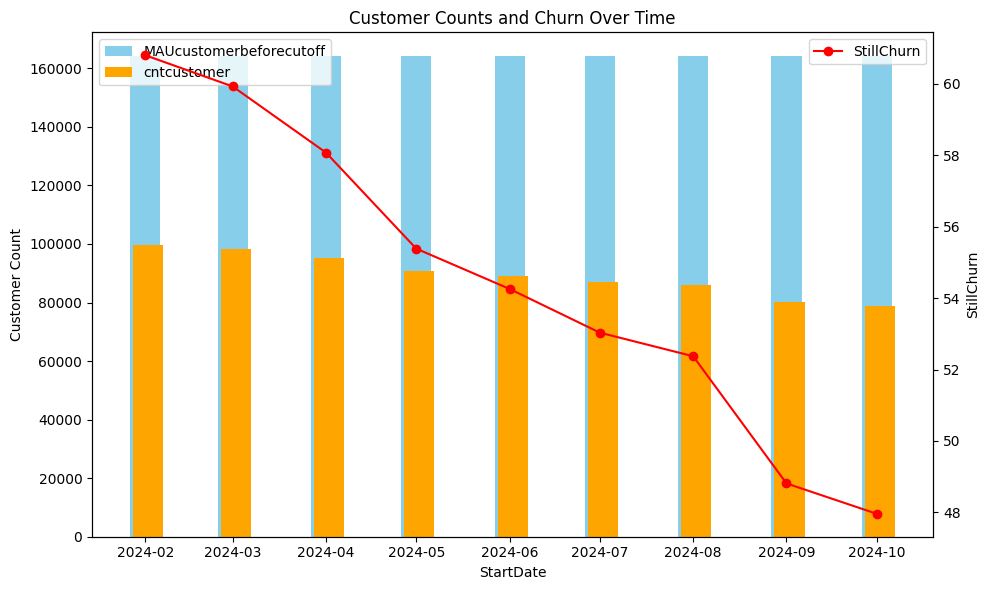

In [38]:
# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Increase the width of the bars
bar_width = 10  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')
ax2.legend(loc='upper right')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

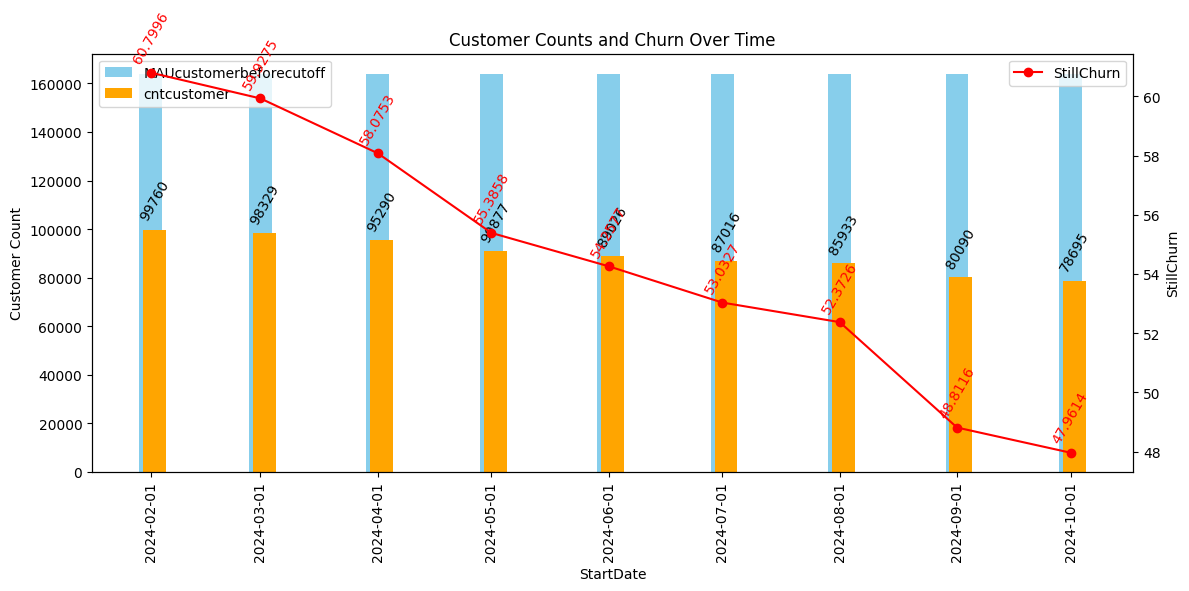

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Increase the width of the bars
bar_width = 6  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
bars1 = ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
bars2 = ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Annotate data values on the cntcustomer bars with 60-degree rotation
for bar, value in zip(bars2, res['cntcustomer']):
    ax1.annotate(f'{value}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', rotation=60)

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
line2, = ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')

# Annotate data values for StillChurn with 60-degree rotation
for x, y in zip(res['StartDate'], res['StillChurn']):
    ax2.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', color='red', rotation=60)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate X-axis labels to be vertical
ax1.set_xticks(res['StartDate'])  # Ensures all x-axis labels are shown
ax1.set_xticklabels(res['StartDate'].dt.strftime('%Y-%m-%d'), rotation=90, ha='center')

# Show the plot
plt.tight_layout()
plt.show()


In [40]:
res.to_excel(r"Churn_analysis_cohort20240201.xlsx")

## Cohort 2023-01-01

In [41]:
import datetime

start_date = datetime.date(2023, 1, 1)
date_str = start_date.strftime('%Y-%m-%d')

## Total Registered Customers before 2023-01-01

In [42]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
)
select * from all_cust ;"""
df = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
print(f"The total registered customers are:{df['registered_users'].nunique()}")

Job ID 76a50390-c230-43fe-bc02-08c7dec6b8c3 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The total registered customers are:846851


## Open TSA Customers

In [43]:
# Define the date and format it as a string in the required format
start_date = datetime.date(2023, 1, 1)
date_str = start_date.strftime('%Y-%m-%d')

# Format the SQL string with the date variable
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) 
    select * from open_TSA_cust;
"""

# Execute the query and convert to a DataFrame
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Open TSA customers before the cutoff date out of the total registered customer are:\t {df['open_TSA_customers'].nunique()}")

df.head()


Job ID 3e2a1efa-f3ec-446b-a6c8-3d205073439f successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Open TSA customers before the cutoff date out of the total registered customer are:	 586066


,open_TSA_customers
0,1690573
1,1688385
2,1688800
3,1690477
4,1689078


In [44]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            ) 
    select customerwithactiveloan from loan_cust;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

print(f"The Customer with active loan on the cutoff date are: {df['customerwithactiveloan'].nunique()}")
df.head()

Job ID 71d9423d-1995-4cfe-bca5-cc3f4d68ddad successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Customer with active loan on the cutoff date are: 21134


,customerwithactiveloan
0,1445383
1,1616763
2,1316766
3,1753828
4,1556238


## ACL Customers

In [45]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                )
    select * from ACL_Customer;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The count ACL customer before the cutoff date are:{df['customerId'].nunique()}")

df.head()

Job ID afe4cc1f-e10f-4a77-9d63-2fb4be429428 successfully executed: 100%|██████████|
Downloading: |          |
The count ACL customer before the cutoff date are:0


,customerId


In [46]:
sq = f"""WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    )
    select * from non_ACL_cust;"""
    
df =client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Non ACL customer count is:{df['customerId'].nunique()}")

df.head()    

Job ID d1308f64-cdd5-462a-b062-a39e69e31655 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Non ACL customer count is:825717


,customerId
0,1084435
1,1084409
2,1084603
3,1084420
4,1084573


## Create the table dap_ds_poweruser_playground.temp_customer_select to store all the customer id who were active at the cohort

In [47]:
sq = """drop table if exists dap_ds_poweruser_playground.temp_customer_select;"""

# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table dropped successfully.")

Table dropped successfully.


In [48]:
sq = f"""
    create table prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select as 
    WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    ),        
    MAU_with_trx --- Customers who at the cutoff date had a transaction of over 100 peso or more
    AS (
        SELECT DISTINCT customer_id 
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date <= date("{date_str}")                            --- Transaction date should be less than the cutoff date
        AND ABS(trx_amount) >= 100                                              --- transaction greater than 100
        AND account_type = "Tonik Account"                                      --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)   --- no active loan
        AND customer_id in (select open_TSA_customers from open_TSA_cust)       --- Active TSA Account
        )
        ,
    MAU_with_bal 
     AS (
        SELECT 
            DISTINCT client_id 
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance >= 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case when account_type like 'Individual Stash' then clearedbalance else 0 end)) >=100
            )                                                                       ---- Balance combined or individual should be more than 100 pseo
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")  ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf <= date("{date_str}") ---- before cutoff date       ---- Balance Date should be less than cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)     ---- Should not have any active loans
            AND client_id in (select open_TSA_customers from open_TSA_cust)         ---- Customer should have active open TSA account
        )         ,
    MAU --- 
        AS (
        SELECT distinct customer_id AS MAU 
        , case when customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction and balance more than 100 peso'
               when  customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id not in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso'
               when  customer_id not in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done no transaction more than 100 peso but have balance more than 100 peso'
               End Mau_condition
        FROM 
            (SELECT customer_id 
            FROM 
                MAU_with_trx
            UNION DISTINCT
            SELECT 
                client_id AS customer_id
            FROM 
                MAU_with_bal))
    select * from MAU;"""
    
# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table successfully Created")



Table successfully Created


In [49]:
df = client.query("""select * from dap_ds_poweruser_playground.temp_customer_select;""").to_dataframe(progress_bar_type='tqdm')

print(f"The count of customer Distribution in MAU before the cutoff date {date_str} is {df.groupby('Mau_condition')['MAU'].nunique()}")
print(f"The count of customer in MAU before the cutoff date {date_str} is {df['MAU'].nunique()}")

Job ID f23d8ae2-889a-4b0b-a7a4-e7bfc75759b3 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The count of customer Distribution in MAU before the cutoff date 2023-01-01 is Mau_condition
Customer done no transaction more than 100 peso but have balance more than 100 peso                      3048
Customer done transaction and balance more than 100 peso                                               106533
Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso     24463
Name: MAU, dtype: int64
The count of customer in MAU before the cutoff date 2023-01-01 is 134044


In [50]:
df.head()

,MAU,Mau_condition
0,1030932,Customer done transaction and balance more tha...
1,1085605,Customer done transaction and balance more tha...
2,1800898,Customer done transaction and balance more tha...
3,1033318,Customer done transaction and balance more tha...
4,1077755,Customer done transaction and balance more tha...


## Check whether we have active loan before the cutoff date

In [51]:
sq = """with loandf as 
(select lmt.customerId, lmt.loanAccountNumber, lmt.disbursementDateTime,lbfrc.bucketDate, lbfrc.loanStatus  
from `risk_credit_mis.loan_master_table` lmt 
inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
where lmt.flagDisbursement = 1)
select *,  
(select max(loanAccountNumber) from loandf where cast(customerId as string) = a.MAU and date_trunc(disbursementDateTime, day) <= '2022-12-31' 
and bucketDate = '2022-12-31' and loanStatus in ('Normal', 'In Arrears')
group by customerId) loanaccount
from prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select a
;
"""
dfd = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

print(dfd['loanaccount'].value_counts(dropna=False))

if dfd['loanaccount'].notna().any():
    print("There is a problem: We have loanAccountNumber active before cutoff date.")
else:
    print("Everything is all right: All loanaccount values are None.")

Job ID ceafadbd-1c28-497b-8755-f040050b2d1e successfully executed: 100%|██████████|
Downloading: 100%|██████████|
loanaccount
None    134044
Name: count, dtype: int64
Everything is all right: All loanaccount values are None.


I now have a dataframe df with Monthly active customer MAU as of cutoff date 2023-07-01 <br>

I need to check now for each subsequent month out of these customers who have never have any:<br> 
1.  active loan, 
2.  Never transacted more than 100 peso
3.  Never have combined balance more than 100 peso
4.  Do not have any active TD account within the date range
5.  TSA is closed after cutoff date after 60 days
6.  TSA is closed after 180 days from the cutoff date


Cohort of 1st of February


In [52]:
import pandas as pd
from datetime import datetime, timedelta

# Start date as the month after 2023-07-01
start_date = pd.to_datetime("2023-01-01") 
# + pd.DateOffset(months=1)
# Today's date
end_date = datetime.today()
# end_date = pd.to_datetime("2023-12-01") 

# Generate month start and month end dates
month_dates = []
current_date = start_date

while current_date <= end_date:
    month_start = current_date.replace(day=1)
    next_month = month_start + pd.DateOffset(months=1)
    month_end = (next_month - timedelta(days=1)) if next_month <= end_date else end_date
    
    month_dates.append((month_start, month_end))
    current_date = next_month

# Display the result
res =  pd.DataFrame()
for start, end in month_dates:
    print(f"Month Start: {start.strftime('%Y-%m-%d')}, Month End: {end.strftime('%Y-%m-%d')}")
    date_str = start.strftime('%Y-%m-%d')
    sq = f"""with 
        loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
        AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)                                   --- bucketDate should be equal to d-1 of cutoff date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')                                                        --- loan paid status should be Normal or In Arears indicating active loans
        and CAST(lmt.customerId AS STRING) in (select MAU from dap_ds_poweruser_playground.temp_customer_select)--- customer from the MAU list before cutoff date
                  ),
        TD_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE not in ('POC20000', 'POC20600', 'POC20400', 'POC20200', 'NULL')   
                            AND
                            (OFDATECLOSED = '1970-01-01' or OFDATECLOSED >= '{date_str}')
                            AND OFDATEOPENED <='{date_str}'
        ),
        TSAClosed60_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND (OFDATECLOSED >= '{date_str}' and OFDATECLOSED <= date_add('{date_str}', interval 60 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        TSAClosed180_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND  OFDATECLOSED > '{date_str}' 
                            AND (OFDATECLOSED > date_add('{date_str}', interval 60 day) AND OFDATECLOSED <= date_add('{date_str}', interval 180 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        MAU_with_trx 
        AS (
        SELECT customer_id , max(trx_amount) condition
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date >= date("{date_str}")                                --- transaction date greater or equal to cutoff dates
        AND ABS(trx_amount) < 100                                                   --- transaction greater than 100
        AND account_type = "Tonik Account"                                          --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)       --- no active loan
        AND customer_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                   --- NO ACTIVE TD ACCOUNT
        group by 1
        )
        ,
        MAU_with_bal 
        AS (
        SELECT 
            client_id, max(clearedbalance) condition
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance < 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case     when account_type like 'Individual Stash' then clearedbalance else 0 end)) < 100
            )
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")      ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf > date("{date_str}")                                    ---- before cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)         ---- no active loans 
            AND client_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                     ---- no active TD account   
            group by 1
        ),
        MAUunion as 
        (
        select *, 'trx' tab from MAU_with_trx
        union distinct
        select *, 'bal' tab from MAU_with_bal
        ), 
        MAUfinal as 
        (select customer_id, max(condition) val, count(distinct tab) cnt_condition
        , max(case when tab = 'trx' then condition else 0 end) trx_amount
        , max(case when tab = 'bal' then condition else 0 end) balanceamt
        , (select max(loanAccountNumber) from `risk_credit_mis.loan_master_table` 
                                        where cast(customerId as string) = customer_id 
                                        and date_trunc(disbursementDateTime, day) >= '{date_str}') loancount
        from MAUunion
        group by 1
        ),
        TSAClosed as 
        (select OFCUSTOMERID, OFDATECLOSED from `core_raw.customer_accounts` 
        where OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select) and CRINTERCODE = 'POC20000' and OFDATECLOSED is not null)
    select 
    (select count(distinct MAU) from dap_ds_poweruser_playground.temp_customer_select) MAUcustomerbeforecutoff,
    count(distinct customer_id) cntcustomer, 
    (select count(distinct OFCUSTOMERID) from TSAClosed where OFDATECLOSED >= '{date_str}') TSAclosed_count,
    (select count(distinct OFCUSTOMERID) from TSAClosed60_cust) TSAClosedAfter60daysofinactivity,
    (select count(distinct OFCUSTOMERID) from TSAClosed180_cust)TSAClosedAfter180daysofinactivity,
    count(distinct case when val > 1 and val < 100 then customer_id end) greaterthan1lessthan100peso,
    count(distinct case when val < 1 then customer_id end) lessthan1peso,
    count(distinct case when cnt_condition > 1 then customer_id end) twoconditionmet,
    count(distinct case when cnt_condition <= 1 then customer_id end) onlyoneconditionmet,
    count(distinct case when trx_amount > 100 then customer_id end) trx_amt_morethan_100,
    count(distinct case when trx_amount between 1 and 100 then customer_id end) trx_amt_oneto100,
    count(distinct case when trx_amount < 1 then customer_id end) trx_amt_less_one,
    count(distinct case when balanceamt > 100 then customer_id end) balance_amt_morethan100,
    count(distinct case when balanceamt between 1 and 100 then customer_id end) balance_amt_oneto100,
    count(distinct case when balanceamt < 1 then customer_id end) balance_amt_less_one,
    count(distinct case when loancount is not null then customer_id end) loansapplied
    from MAUfinal
    where customer_id in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
    order by 1 desc        
    """
    df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
    df['StartDate'] = date_str
    df['StillChurn'] = round(df['cntcustomer']/df['MAUcustomerbeforecutoff']*100, 4)
    res = pd.concat([res,df])
    
res = res[['StartDate', 'MAUcustomerbeforecutoff', 'cntcustomer', 'StillChurn', 'TSAclosed_count',
        'TSAClosedAfter60daysofinactivity', 'TSAClosedAfter180daysofinactivity',
        'greaterthan1lessthan100peso',
       'lessthan1peso', 'twoconditionmet', 'onlyoneconditionmet',
       'trx_amt_morethan_100', 'trx_amt_oneto100', 'trx_amt_less_one',
       'balance_amt_morethan100', 'balance_amt_oneto100',
       'balance_amt_less_one', 'loansapplied']].copy()
res

Month Start: 2023-01-01, Month End: 2023-01-31
Job ID 8b94c144-c76d-411e-bda0-7c34e5ce5f2d successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-02-01, Month End: 2023-02-28
Job ID c93cf929-9395-4ed3-807d-89b3fccf134f successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-03-01, Month End: 2023-03-31
Job ID dea28205-be17-46b7-ad6e-4b17d3f1003c successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-04-01, Month End: 2023-04-30
Job ID ba4aa04a-f501-4e2b-aa1e-97ff4a50b894 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-05-01, Month End: 2023-05-31
Job ID 7665a783-c75a-493d-90ac-b1c0879d985a successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-06-01, Month End: 2023-06-30
Job ID cdeee3cf-72a8-42c9-800f-69cb76972ccc successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-07-01, Month End: 2023-07-31
Job ID 4eba

,StartDate,MAUcustomerbeforecutoff,cntcustomer,StillChurn,TSAclosed_count,TSAClosedAfter60daysofinactivity,TSAClosedAfter180daysofinactivity,greaterthan1lessthan100peso,lessthan1peso,twoconditionmet,onlyoneconditionmet,trx_amt_morethan_100,trx_amt_oneto100,trx_amt_less_one,balance_amt_morethan100,balance_amt_oneto100,balance_amt_less_one,loansapplied
0,2023-01-01,134044,78947,58.8963,33972,3033,10933,48795,30002,17508,61439,0,13092,65855,0,47766,31181,1901
0,2023-02-01,134044,77416,57.7542,33577,6290,9571,47248,30021,15924,61492,0,11785,65631,0,46463,30953,1599
0,2023-03-01,134044,74509,55.5855,30948,7465,7448,46304,28060,14783,59726,0,10911,63598,0,45680,28829,1454
0,2023-04-01,134044,70345,52.479,27330,5099,6547,45198,25008,13699,56646,0,10052,60293,0,44684,25661,1253
0,2023-05-01,134044,67580,50.4163,23483,3477,7769,44291,23155,12842,54738,0,9364,58216,0,43818,23762,1109
0,2023-06-01,134044,64676,48.2498,22231,4515,6675,43292,21251,11908,52768,0,8643,56033,0,42853,21823,987
0,2023-07-01,134044,63722,47.5381,20006,3995,5773,42376,21213,11095,52627,0,8056,55666,0,42002,21720,865
0,2023-08-01,134044,61486,45.87,17716,2064,6165,41651,19704,10373,51113,0,7512,53974,0,41320,20166,759
0,2023-09-01,134044,59789,44.604,16004,3802,2835,41009,18655,9663,50126,0,6961,52828,0,40707,19082,665
0,2023-10-01,134044,59272,44.2183,15652,4633,2454,40556,18594,9140,50132,0,6519,52753,0,40276,18996,602


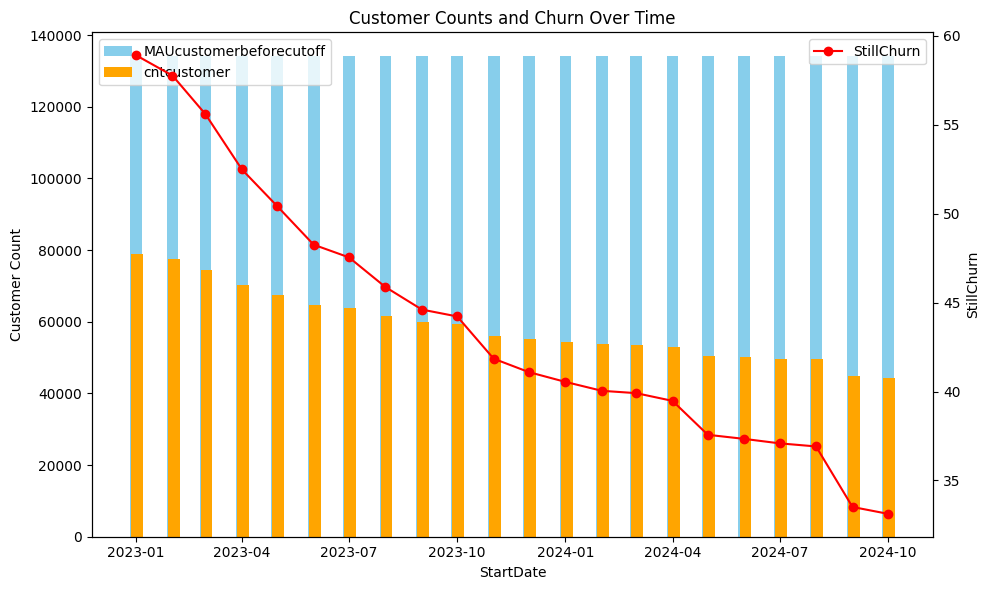

In [53]:
# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Increase the width of the bars
bar_width = 10  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')
ax2.legend(loc='upper right')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

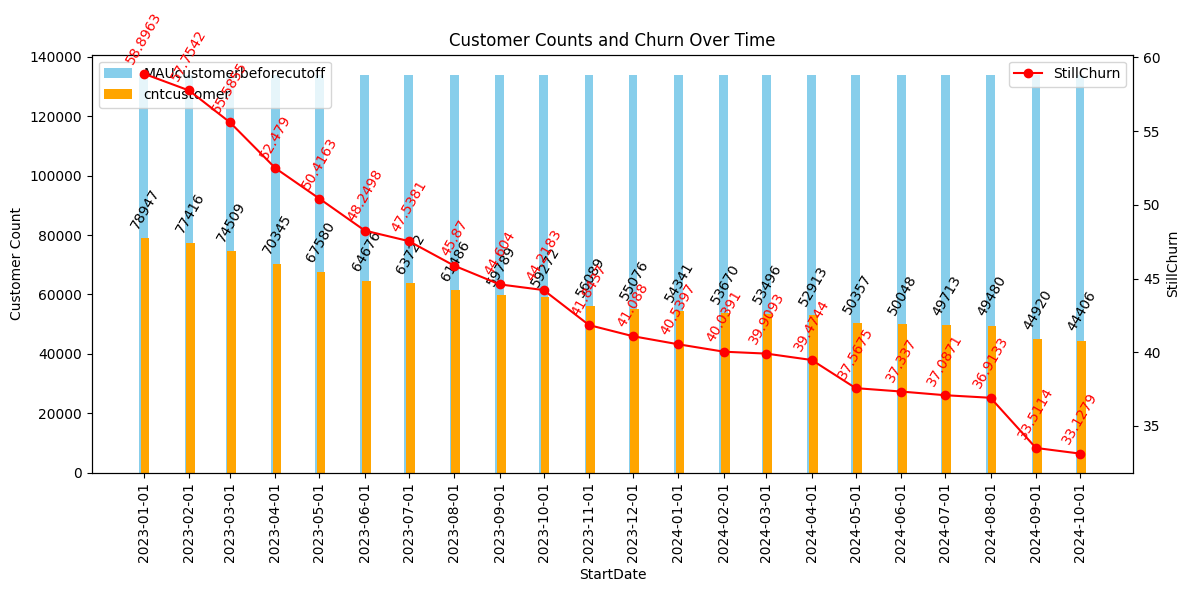

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Increase the width of the bars
bar_width = 6  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
bars1 = ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
bars2 = ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Annotate data values on the cntcustomer bars with 60-degree rotation
for bar, value in zip(bars2, res['cntcustomer']):
    ax1.annotate(f'{value}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', rotation=60)

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
line2, = ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')

# Annotate data values for StillChurn with 60-degree rotation
for x, y in zip(res['StartDate'], res['StillChurn']):
    ax2.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', color='red', rotation=60)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate X-axis labels to be vertical
ax1.set_xticks(res['StartDate'])  # Ensures all x-axis labels are shown
ax1.set_xticklabels(res['StartDate'].dt.strftime('%Y-%m-%d'), rotation=90, ha='center')

# Show the plot
plt.tight_layout()
plt.show()


In [55]:
res.to_excel(r"Churn_analysis_cohort20230101.xlsx")

## Cohort 2023-10-01

In [56]:
import datetime

start_date = datetime.date(2023, 10, 1)
date_str = start_date.strftime('%Y-%m-%d')

## Total Registered Customers before 2023-10-01

In [57]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
)
select * from all_cust ;"""
df = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
print(f"The total registered customers are:{df['registered_users'].nunique()}")

Job ID 2bd34ec8-9f8c-405b-bfaf-bf6219de5973 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The total registered customers are:1255361


## Open TSA Customers

In [58]:
# Define the date and format it as a string in the required format
start_date = datetime.date(2023, 10, 1)
date_str = start_date.strftime('%Y-%m-%d')

# Format the SQL string with the date variable
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) 
    select * from open_TSA_cust;
"""

# Execute the query and convert to a DataFrame
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Open TSA customers before the cutoff date out of the total registered customer are:\t {df['open_TSA_customers'].nunique()}")

df.head()


Job ID b7fe4fea-4419-4370-a351-572664ac849d successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Open TSA customers before the cutoff date out of the total registered customer are:	 547921


,open_TSA_customers
0,2226630
1,2227227
2,2226599
3,2227086
4,2227238


In [59]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            ) 
    select customerwithactiveloan from loan_cust;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')

print(f"The Customer with active loan on the cutoff date are: {df['customerwithactiveloan'].nunique()}")
df.head()

Job ID 6e9ee673-395a-496b-b4a4-acbbf80184f6 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Customer with active loan on the cutoff date are: 35128


,customerwithactiveloan
0,2227871
1,1192712
2,1890933
3,1698912
4,2083301


## ACL Customers

In [60]:
sq = f"""            
WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                )
    select * from ACL_Customer;"""
    
df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The count ACL customer before the cutoff date are:{df['customerId'].nunique()}")

df.head()

Job ID 50a1eb0f-da4c-4153-8253-58107e0c8fc6 successfully executed: 100%|██████████|
Downloading: |          |
The count ACL customer before the cutoff date are:0


,customerId


In [61]:
sq = f"""WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    )
    select * from non_ACL_cust;"""
    
df =client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The Non ACL customer count is:{df['customerId'].nunique()}")

df.head()    

Job ID 2e1e7e79-7c63-4b67-a3e2-b0b40ee587b0 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The Non ACL customer count is:1220233


,customerId
0,2015816
1,2016811
2,2015824
3,2015644
4,2016232


## Create the table dap_ds_poweruser_playground.temp_customer_select to store all the customer id who were active at the cohort

In [62]:
sq = """drop table if exists dap_ds_poweruser_playground.temp_customer_select;"""

# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table dropped successfully.")

Table dropped successfully.


In [63]:
print(f"The date check is: {date_str}")

The date check is: 2023-10-01


In [64]:
sq = f"""
    create table prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select as 
    WITH all_cust AS (
    SELECT DISTINCT cust_id AS registered_users
    FROM `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
    WHERE created_dt <= "{date_str}" AND cust_id IS NOT NULL 
),
    open_TSA_cust --- TSA customer which was opened before the cut off date and closed date is either null or greater than cutoff date
    AS(
        SELECT OFCUSTOMERID open_TSA_customers from `core_raw.customer_accounts` 
            where CRINTERDESC like 'Transactional Savings Account Inv_R'
            and OFCUSTOMERID in (select distinct cust_id 
            from prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb where cust_id is not null)
            AND OFDATEOPENED <= "{date_str}"
            AND (OFDATECLOSED = DATE('1970-01-01') OR  OFDATECLOSED > "{date_str}")
            AND OFCUSTOMERID in (select registered_users from all_cust)
            ) ,
    loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
    AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)  --- need to change the date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')
            )             ,
    ACL_Customer ---- ACL customer are TSBL loans with sub product type FP and disbursement date <= cutoff date
        as 
            (select lmt.customerId FROM `prj-prod-dataplatform.dl_loans_db_raw.tdbk_digital_loan_application` a
                inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = a.digitalLoanAccountId
                where coalesce(a.loanType, 'NA') = 'TSBL'and coalesce(a.loan_sub_product_type, 'NA') = 'FP'
                and date_trunc(a.loanDigitalAppliedDateAndTime, day) <= "{date_str}"
                and date_trunc(lmt.disbursementDateTime, day) <= "{date_str}" --- need to change the date
                ),
    non_ACL_cust --list of all customers who have no ACL loans (loatype TSBL and sub-product type FP)
    AS (
        SELECT 
            distinct CAST(cust_id AS STRING) customerId
        FROM 
            `prj-prod-dataplatform.dl_customers_db_raw.tdbk_customer_mtb`
        WHERE 
            cast(cust_id as string) not in (select customerwithactiveloan from loan_cust)
            and created_dt <= "{date_str}" and cust_id is not null 
    ),        
    MAU_with_trx --- Customers who at the cutoff date had a transaction of over 100 peso or more
    AS (
        SELECT DISTINCT customer_id 
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date <= date("{date_str}")                            --- Transaction date should be less than the cutoff date
        AND ABS(trx_amount) >= 100                                              --- transaction greater than 100
        AND account_type = "Tonik Account"                                      --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)   --- no active loan
        AND customer_id in (select open_TSA_customers from open_TSA_cust)       --- Active TSA Account
        )
        ,
    MAU_with_bal 
     AS (
        SELECT 
            DISTINCT client_id 
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance >= 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case when account_type like 'Individual Stash' then clearedbalance else 0 end)) >=100
            )                                                                       ---- Balance combined or individual should be more than 100 pseo
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")  ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf <= date("{date_str}") ---- before cutoff date       ---- Balance Date should be less than cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)     ---- Should not have any active loans
            AND client_id in (select open_TSA_customers from open_TSA_cust)         ---- Customer should have active open TSA account
        )         ,
    MAU --- 
        AS (
        SELECT distinct customer_id AS MAU 
        , case when customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction and balance more than 100 peso'
               when  customer_id in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id not in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso'
               when  customer_id not in (SELECT customer_id  FROM  MAU_with_trx ) and customer_id in (SELECT  client_id AS customer_id  FROM  MAU_with_bal) then 'Customer done no transaction more than 100 peso but have balance more than 100 peso'
               End Mau_condition
        FROM 
            (SELECT customer_id 
            FROM 
                MAU_with_trx
            UNION DISTINCT
            SELECT 
                client_id AS customer_id
            FROM 
                MAU_with_bal))
    select * from MAU;"""
    
# Run the query
query_job = client.query(sq)  # Make an API request

# Wait for the query to complete
query_job.result()

print("Table successfully Created")



Table successfully Created


In [65]:
df = client.query("""select * from dap_ds_poweruser_playground.temp_customer_select;""").to_dataframe(progress_bar_type='tqdm')

print(f"The count of customer Distribution in MAU before the cutoff date {date_str} is {df.groupby('Mau_condition')['MAU'].nunique()}")
print(f"The count of customer in MAU before the cutoff date {date_str} is {df['MAU'].nunique()}")

Job ID 691b39fa-2d92-46b2-93b0-59a49b027ae8 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The count of customer Distribution in MAU before the cutoff date 2023-10-01 is Mau_condition
Customer done no transaction more than 100 peso but have balance more than 100 peso                      2859
Customer done transaction and balance more than 100 peso                                               134041
Customer done transaction with transaction amount more than 100 peso but balance less than 100 peso     24915
Name: MAU, dtype: int64
The count of customer in MAU before the cutoff date 2023-10-01 is 161815


In [66]:
df.head()

,MAU,Mau_condition
0,1516747,Customer done transaction and balance more tha...
1,1272631,Customer done transaction and balance more tha...
2,1555011,Customer done transaction and balance more tha...
3,1415748,Customer done transaction and balance more tha...
4,1399009,Customer done transaction and balance more tha...


## Check whether we have active loan before the cutoff date

In [67]:
sq = """with loandf as 
(select lmt.customerId, lmt.loanAccountNumber, lmt.disbursementDateTime,lbfrc.bucketDate, lbfrc.loanStatus  
from `risk_credit_mis.loan_master_table` lmt 
inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
where lmt.flagDisbursement = 1)
select *,  
(select max(loanAccountNumber) from loandf where cast(customerId as string) = a.MAU and date_trunc(disbursementDateTime, day) <= '2023-09-30' 
and bucketDate = '2023-09-30' and loanStatus in ('Normal', 'In Arrears')
group by customerId) loanaccount
from prj-prod-dataplatform.dap_ds_poweruser_playground.temp_customer_select a
;
"""
dfd = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

print(dfd['loanaccount'].value_counts(dropna=False))

if dfd['loanaccount'].notna().any():
    print("There is a problem: We have loanAccountNumber active before cutoff date.")
else:
    print("Everything is all right: All loanaccount values are None.")

Job ID 151d4ee2-cbb0-4178-9c43-dcaf28c69476 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
loanaccount
None    161815
Name: count, dtype: int64
Everything is all right: All loanaccount values are None.


I now have a dataframe df with Monthly active customer MAU as of cutoff date 2023-07-01 <br>

I need to check now for each subsequent month out of these customers who have never have any:<br> 
1.  active loan, 
2.  Never transacted more than 100 peso
3.  Never have combined balance more than 100 peso
4.  Do not have any active TD account within the date range
5.  TSA is closed after cutoff date after 60 days
6.  TSA is closed after 180 days from the cutoff date


Cohort of 1st of February


In [68]:
import pandas as pd
from datetime import datetime, timedelta

# Start date as the month after 2023-07-01
start_date = pd.to_datetime("2023-10-01") 
# + pd.DateOffset(months=1)
# Today's date
end_date = datetime.today()
# end_date = pd.to_datetime("2023-12-01") 

# Generate month start and month end dates
month_dates = []
current_date = start_date

while current_date <= end_date:
    month_start = current_date.replace(day=1)
    next_month = month_start + pd.DateOffset(months=1)
    month_end = (next_month - timedelta(days=1)) if next_month <= end_date else end_date
    
    month_dates.append((month_start, month_end))
    current_date = next_month

# Display the result
res =  pd.DataFrame()
for start, end in month_dates:
    print(f"Month Start: {start.strftime('%Y-%m-%d')}, Month End: {end.strftime('%Y-%m-%d')}")
    date_str = start.strftime('%Y-%m-%d')
    sq = f"""with 
        loan_cust --list of customers having loan either in status Normal or Arrears at the cut off date
        AS (
        SELECT 
            distinct CAST(lmt.customerId AS STRING) customerwithactiveloan
        FROM 
            `prj-prod-dataplatform.risk_credit_mis.loan_master_table` lmt
            inner join prj-prod-dataplatform.risk_credit_mis.loan_bucket_flow_report_core lbfrc on lbfrc.loanAccountNumber = lmt.loanAccountNumber
        WHERE lbfrc.bucketDate = date_sub(date("{date_str}"), interval 1 day)                                   --- bucketDate should be equal to d-1 of cutoff date
        and lbfrc.loanStatus IN ('Normal', 'In Arrears')                                                        --- loan paid status should be Normal or In Arears indicating active loans
        and CAST(lmt.customerId AS STRING) in (select MAU from dap_ds_poweruser_playground.temp_customer_select)--- customer from the MAU list before cutoff date
                  ),
        TD_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE not in ('POC20000', 'POC20600', 'POC20400', 'POC20200', 'NULL')   
                            AND
                            (OFDATECLOSED = '1970-01-01' or OFDATECLOSED >= '{date_str}')
                            AND OFDATEOPENED <='{date_str}'
        ),
        TSAClosed60_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND (OFDATECLOSED >= '{date_str}' and OFDATECLOSED <= date_add('{date_str}', interval 60 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        TSAClosed180_cust as (select CRINTERCODE, CRINTERDESC , OFCUSTOMERID
                            , OFDATEOPENED
                            , OFDATECLOSED
                            from `core_raw.customer_accounts` 
                            where CRINTERCODE in ('POC20000')   
                            AND  OFDATECLOSED > '{date_str}' 
                            AND (OFDATECLOSED > date_add('{date_str}', interval 60 day) AND OFDATECLOSED <= date_add('{date_str}', interval 180 day))
                            AND OFDATEOPENED <='{date_str}'
                            AND OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
        ),
        MAU_with_trx 
        AS (
        SELECT customer_id , max(trx_amount) condition
        FROM `prj-prod-dataplatform.risk_mart.customer_transactions`
        WHERE transaction_date >= date("{date_str}")                                --- transaction date greater or equal to cutoff dates
        AND ABS(trx_amount) < 100                                                   --- transaction greater than 100
        AND account_type = "Tonik Account"                                          --- TSA account type
        AND customer_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)       --- no active loan
        AND customer_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                   --- NO ACTIVE TD ACCOUNT
        group by 1
        )
        ,
        MAU_with_bal 
        AS (
        SELECT 
            client_id, max(clearedbalance) condition
        FROM 
            `prj-prod-dataplatform.risk_mart.customer_balance`
        WHERE
            (clearedbalance < 100  --- balance in any account greater than 100
            or ((case when account_type like 'Tonik Account' then clearedbalance else 0 end) + (case when account_type like 'Group Stash' then clearedbalance else 0 end) + (case     when account_type like 'Individual Stash' then clearedbalance else 0 end)) < 100
            )
            AND account_type IN ("Tonik Account","Group Stash","Individual Stash")      ---- TSA, Group Stash and Individual Stash
            AND balanceDateAsOf > date("{date_str}")                                    ---- before cutoff date
            AND client_id NOT IN (SELECT customerwithactiveloan FROM loan_cust)         ---- no active loans 
            AND client_id NOT IN (SELECT OFCUSTOMERID FROM TD_cust)                     ---- no active TD account   
            group by 1
        ),
        MAUunion as 
        (
        select *, 'trx' tab from MAU_with_trx
        union distinct
        select *, 'bal' tab from MAU_with_bal
        ), 
        MAUfinal as 
        (select customer_id, max(condition) val, count(distinct tab) cnt_condition
        , max(case when tab = 'trx' then condition else 0 end) trx_amount
        , max(case when tab = 'bal' then condition else 0 end) balanceamt
        , (select max(loanAccountNumber) from `risk_credit_mis.loan_master_table` 
                                        where cast(customerId as string) = customer_id 
                                        and date_trunc(disbursementDateTime, day) >= '{date_str}') loancount
        from MAUunion
        group by 1
        ),
        TSAClosed as 
        (select OFCUSTOMERID, OFDATECLOSED from `core_raw.customer_accounts` 
        where OFCUSTOMERID in (select MAU from dap_ds_poweruser_playground.temp_customer_select) and CRINTERCODE = 'POC20000' and OFDATECLOSED is not null)
    select 
    (select count(distinct MAU) from dap_ds_poweruser_playground.temp_customer_select) MAUcustomerbeforecutoff,
    count(distinct customer_id) cntcustomer, 
    (select count(distinct OFCUSTOMERID) from TSAClosed where OFDATECLOSED >= '{date_str}') TSAclosed_count,
    (select count(distinct OFCUSTOMERID) from TSAClosed60_cust) TSAClosedAfter60daysofinactivity,
    (select count(distinct OFCUSTOMERID) from TSAClosed180_cust)TSAClosedAfter180daysofinactivity,
    count(distinct case when val > 1 and val < 100 then customer_id end) greaterthan1lessthan100peso,
    count(distinct case when val < 1 then customer_id end) lessthan1peso,
    count(distinct case when cnt_condition > 1 then customer_id end) twoconditionmet,
    count(distinct case when cnt_condition <= 1 then customer_id end) onlyoneconditionmet,
    count(distinct case when trx_amount > 100 then customer_id end) trx_amt_morethan_100,
    count(distinct case when trx_amount between 1 and 100 then customer_id end) trx_amt_oneto100,
    count(distinct case when trx_amount < 1 then customer_id end) trx_amt_less_one,
    count(distinct case when balanceamt > 100 then customer_id end) balance_amt_morethan100,
    count(distinct case when balanceamt between 1 and 100 then customer_id end) balance_amt_oneto100,
    count(distinct case when balanceamt < 1 then customer_id end) balance_amt_less_one,
    count(distinct case when loancount is not null then customer_id end) loansapplied
    from MAUfinal
    where customer_id in (select MAU from dap_ds_poweruser_playground.temp_customer_select)
    order by 1 desc        
    """
    df = client.query(sq).to_dataframe(progress_bar_type='tqdm')
    df['StartDate'] = date_str
    df['StillChurn'] = round(df['cntcustomer']/df['MAUcustomerbeforecutoff']*100, 4)
    res = pd.concat([res,df])
    
res = res[['StartDate', 'MAUcustomerbeforecutoff', 'cntcustomer', 'StillChurn', 'TSAclosed_count',
        'TSAClosedAfter60daysofinactivity', 'TSAClosedAfter180daysofinactivity',
        'greaterthan1lessthan100peso',
       'lessthan1peso', 'twoconditionmet', 'onlyoneconditionmet',
       'trx_amt_morethan_100', 'trx_amt_oneto100', 'trx_amt_less_one',
       'balance_amt_morethan100', 'balance_amt_oneto100',
       'balance_amt_less_one', 'loansapplied']].copy()
res

Month Start: 2023-10-01, Month End: 2023-10-31
Job ID 04d837eb-e336-4b5e-b852-3b5d1d2d8976 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-11-01, Month End: 2023-11-30
Job ID 691eaf0a-776f-40e0-b118-d5433f634c2e successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2023-12-01, Month End: 2023-12-31
Job ID 5108e3ad-fe0b-46ac-a106-1bf7113f7c68 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-01-01, Month End: 2024-01-31
Job ID c551325c-0026-4e1f-9f3a-4d5aa9244a5c successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-02-01, Month End: 2024-02-29
Job ID 75659034-356e-45cd-b464-ef1e67b291c7 successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-03-01, Month End: 2024-03-31
Job ID 110432ce-8072-44a0-927b-21be7e3fa09a successfully executed: |          |
Downloading: 100%|██████████|
Month Start: 2024-04-01, Month End: 2024-04-30
Job ID 79de

,StartDate,MAUcustomerbeforecutoff,cntcustomer,StillChurn,TSAclosed_count,TSAClosedAfter60daysofinactivity,TSAClosedAfter180daysofinactivity,greaterthan1lessthan100peso,lessthan1peso,twoconditionmet,onlyoneconditionmet,trx_amt_morethan_100,trx_amt_oneto100,trx_amt_less_one,balance_amt_morethan100,balance_amt_oneto100,balance_amt_less_one,loansapplied
0,2023-10-01,161815,99232,61.3244,28918,7592,7244,55012,44041,13815,85417,0,9544,89688,0,54475,44757,1800
0,2023-11-01,161815,94103,58.1547,23901,4215,9750,53641,40279,12699,81404,0,8770,85333,0,53172,40931,1535
0,2023-12-01,161815,91381,56.4725,21327,3481,9343,52771,38430,11869,79512,0,8142,83239,0,52345,39036,1352
0,2024-01-01,161815,89568,55.3521,19686,2686,10037,51960,37433,11085,78483,0,7568,82000,0,51548,38020,1157
0,2024-02-01,161815,87601,54.1365,17833,3840,7678,51171,36259,10283,77318,0,6968,80633,0,50778,36823,1074
0,2024-03-01,161815,86532,53.4759,17004,7084,4585,50499,35867,9437,77095,0,6370,80162,0,50144,36388,987
0,2024-04-01,161815,83688,51.7183,14026,5581,7957,49921,33603,8731,74957,0,5869,77819,0,49590,34098,934
0,2024-05-01,161815,79494,49.1265,9920,2998,6922,48573,30766,7962,71532,0,5342,74152,0,48263,31231,844
0,2024-06-01,161815,77919,48.1531,8445,2142,6303,47946,29821,7182,70737,0,4787,73132,0,47660,30259,767
0,2024-07-01,161815,76285,47.1433,6922,5802,1120,47200,28941,6232,70053,0,4062,72223,0,46935,29350,664


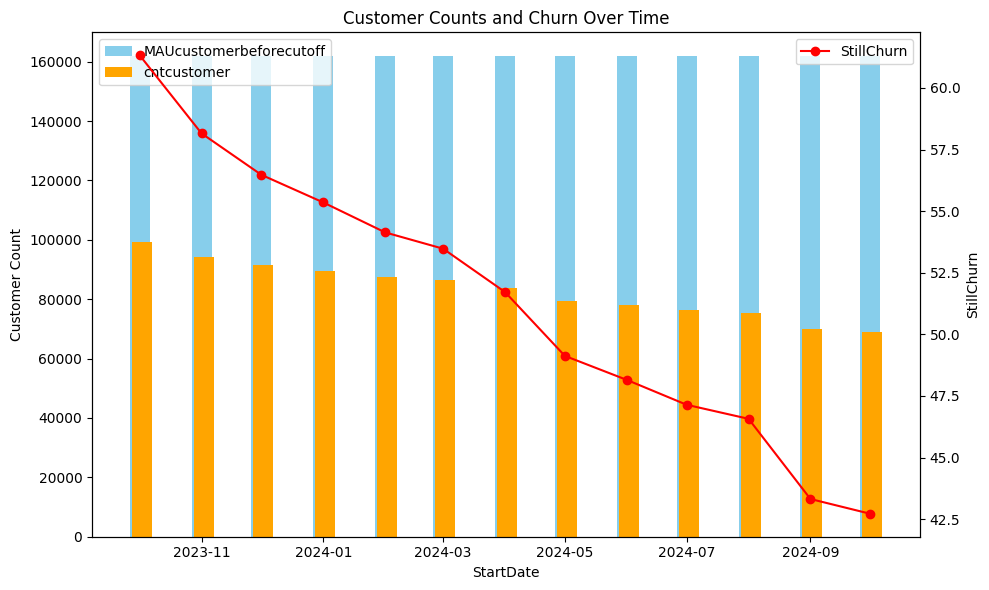

In [69]:
# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Increase the width of the bars
bar_width = 10  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')
ax2.legend(loc='upper right')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

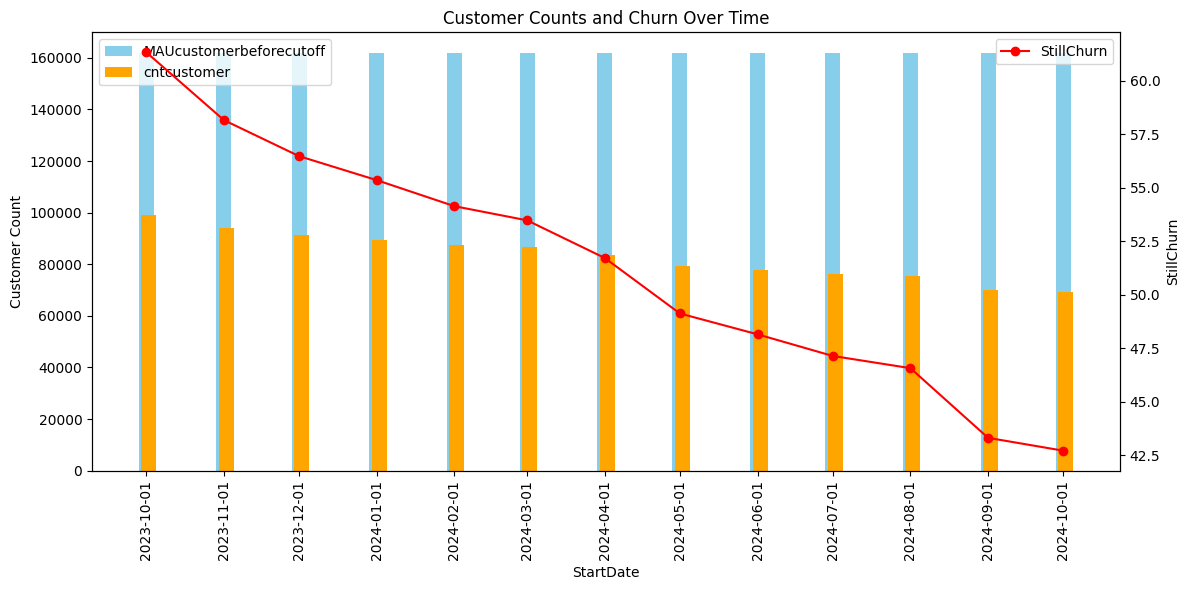

In [70]:
# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Increase the width of the bars
bar_width = 6  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')
ax2.legend(loc='upper right')

# Rotate X-axis labels to be vertical
ax1.set_xticks(res['StartDate'])  # Ensures all x-axis labels are shown
ax1.set_xticklabels(res['StartDate'].dt.strftime('%Y-%m-%d'), rotation=90, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
res.to_excel(r"Churn_analysis_cohort20231001.xlsx")

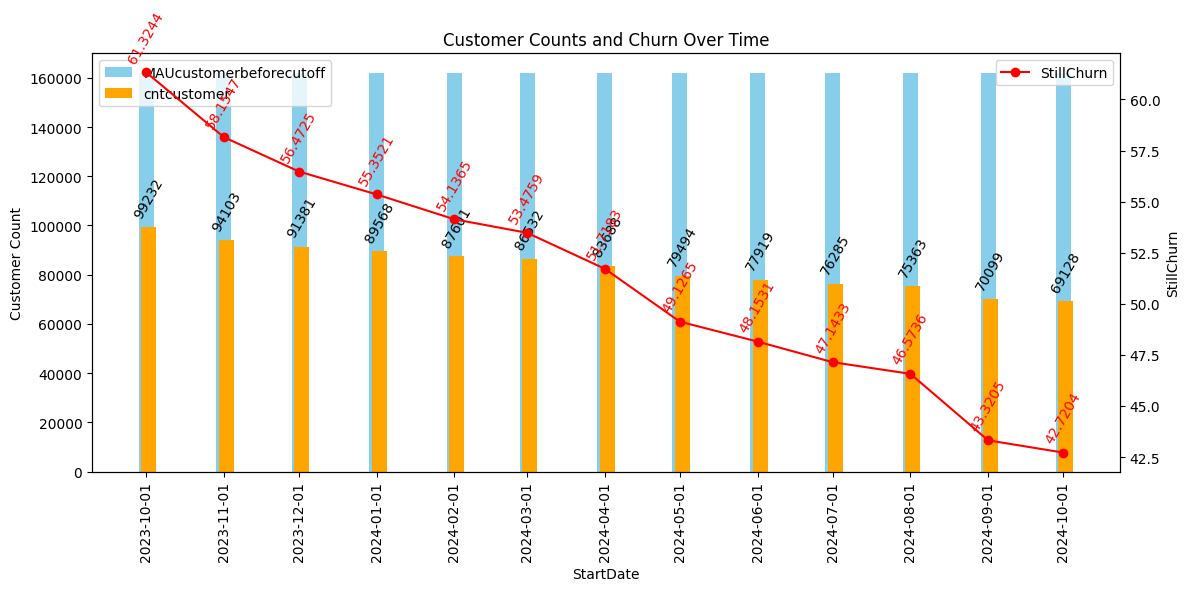

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'StartDate' is in datetime format for proper plotting
res['StartDate'] = pd.to_datetime(res['StartDate'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Increase the width of the bars
bar_width = 6  # Adjust as needed for the desired thickness

# Plot the bar charts for MAUcustomerbeforecutoff and cntcustomer
bars1 = ax1.bar(res['StartDate'], res['MAUcustomerbeforecutoff'], width=bar_width, label='MAUcustomerbeforecutoff', color='skyblue', align='center')
bars2 = ax1.bar(res['StartDate'] + pd.Timedelta(days=1), res['cntcustomer'], width=bar_width, label='cntcustomer', color='orange', align='center')

# Annotate data values on the cntcustomer bars with 60-degree rotation
for bar, value in zip(bars2, res['cntcustomer']):
    ax1.annotate(f'{value}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', rotation=60)

# Set labels and titles
ax1.set_xlabel('StartDate')
ax1.set_ylabel('Customer Count')
ax1.set_title('Customer Counts and Churn Over Time')
ax1.legend(loc='upper left')

# Secondary axis for StillChurn
ax2 = ax1.twinx()
line2, = ax2.plot(res['StartDate'], res['StillChurn'], color='red', marker='o', label='StillChurn')
ax2.set_ylabel('StillChurn')

# Annotate data values for StillChurn with 60-degree rotation
for x, y in zip(res['StartDate'], res['StillChurn']):
    ax2.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', color='red', rotation=60)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate X-axis labels to be vertical
ax1.set_xticks(res['StartDate'])  # Ensures all x-axis labels are shown
ax1.set_xticklabels(res['StartDate'].dt.strftime('%Y-%m-%d'), rotation=90, ha='center')

# Show the plot
plt.tight_layout()
plt.show()
